<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter10/model_calibration_on_Kaggle_HR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [Brief about Data](https://www.kaggle.com/datasets/jacksonchou/hr-data-for-analytics#Breif-about-Data-:)

Data is about Human resources in a specific company each record represents an employee

#### [Variables description](https://www.kaggle.com/code/ahmedhas93/hr-data-cleaning-outliers-analysis-eda-lr-rf/notebook#Variables-description-:)

Dependent variable

-   Left : 0 if employee did not leave , 1 if left company

Independent variables

-   satisfaction_level : means how much employee satisfied (0 less satisfied , 1 most satisfied)
-   last_evaluation : means employees' evaluation for last month (0 bad , 1 Excellent)
-   number_project : number of projects the employee worked on
-   average_montly_hours : average months employee spends at work per month
-   time_spend_company : years the employee spent in a company
-   Work_accident : 0 if he did not have an accident , 1 if had at least one
-   promotion_last_5years : 0 if he did not have any promotion in last 5 years , 1 if had at least one
-   sales : department in which employee works


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import brier_score_loss

In [2]:
!wget https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Imbalanced-Data/main/chapter10/HR_comma_sep.csv

--2023-10-15 01:27:52--  https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Imbalanced-Data/main/chapter10/HR_comma_sep.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566778 (553K) [text/plain]
Saving to: ‘HR_comma_sep.csv’

HR_comma_sep.csv    100%[===================>] 553.49K  --.-KB/s    in 0.1s    

2023-10-15 01:27:53 (3.72 MB/s) - ‘HR_comma_sep.csv’ saved [566778/566778]



# EDA

In [3]:
# Load the dataset
df = pd.read_csv("HR_comma_sep.csv")

In [4]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


# Check Data imbalance

0    11428
1     3571
Name: left, dtype: int64


<Axes: >

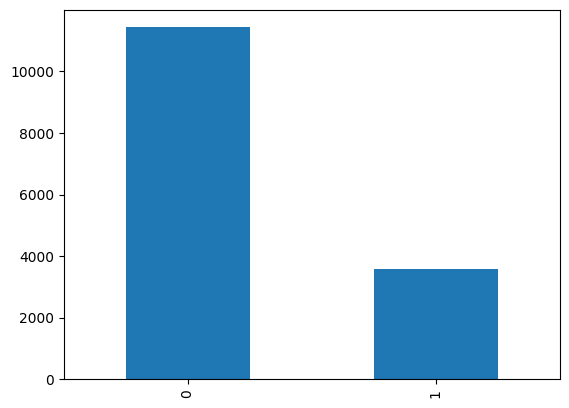

In [5]:
import seaborn as sns

print(df["left"].value_counts())
df["left"].value_counts().plot(kind="bar")

# Convert categorical columns to label encoded

In [6]:
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == object:
        df[column] = le.fit_transform(df[column])

In [7]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,8,1
14995,0.37,0.48,2,160,3,0,1,0,8,1
14996,0.37,0.53,2,143,3,0,1,0,8,1
14997,0.11,0.96,6,280,4,0,1,0,8,1


In [8]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(df.drop("left", axis=1).to_numpy())
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3,4,5,6,7,8
0,-0.936495,-1.087275,-1.462863,-0.882040,-0.341235,-0.411165,-0.147412,0.393725,-0.554955
1,0.752814,0.840707,0.971113,1.220423,1.713436,-0.411165,-0.147412,0.393725,1.043004
2,-2.022479,0.957554,2.593763,1.420657,0.343655,-0.411165,-0.147412,0.393725,1.043004
3,0.431041,0.899131,0.971113,0.439508,1.028546,-0.411165,-0.147412,0.393725,-0.554955
4,-0.976716,-1.145699,-1.462863,-0.841993,-0.341235,-0.411165,-0.147412,0.393725,-0.554955
...,...,...,...,...,...,...,...,...,...
14994,-0.856051,-0.853580,-1.462863,-1.002181,-0.341235,-0.411165,-0.147412,0.742316,-0.554955
14995,-0.976716,-1.379394,-1.462863,-0.821970,-0.341235,-0.411165,-0.147412,0.742316,-0.554955
14996,-0.976716,-1.087275,-1.462863,-1.162368,-0.341235,-0.411165,-0.147412,0.742316,-0.554955
14997,-2.022479,1.424944,1.782438,1.580845,0.343655,-0.411165,-0.147412,0.742316,-0.554955


In [9]:
X = df_scaled
y = df["left"]
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)
print(len(X_train))
print(len(X_val))
print(len(X_test))

11999
1500
1500




# Split the data into training, testing, and validation sets



# Train a random forest model


In [10]:
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=49, max_depth=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9446666666666667

# Plot calibration curve for raw model

In [11]:
# Get the model probabilities on the test set (uncalibrated model)
probs_uncalibrated = model.predict_proba(X_test)[:, 1]

# Calculate Brier score for the uncalibrated model
brier_uncalibrated = brier_score_loss(y_test, probs_uncalibrated)
print(f"Brier Score for Uncalibrated Model: {round(brier_uncalibrated, 4)}")

# Compute the calibration curve for the uncalibrated model
(
    fraction_of_positives_uncalibrated,
    mean_predicted_value_uncalibrated,
) = calibration_curve(y_test, probs_uncalibrated, n_bins=5, strategy="uniform")

Brier Score for Uncalibrated Model: 0.0447


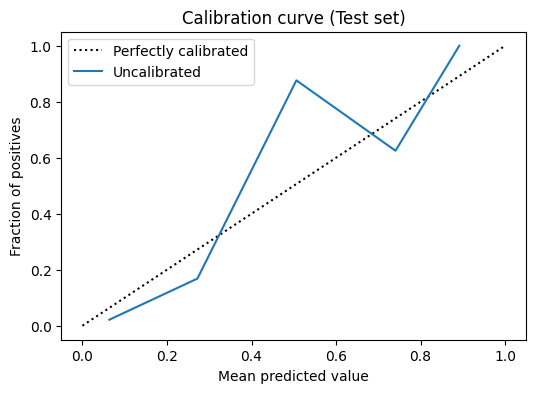

In [12]:
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(
    mean_predicted_value_uncalibrated,
    fraction_of_positives_uncalibrated,
    label="Uncalibrated",
)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve (Test set)")
plt.legend()
plt.show()

# Calibration using Platt's scaling

In [13]:
# Calibrate the model on the validation data using Platt's scaling
platt_scaling = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
platt_scaling.fit(X_val, y_val)

# Get the model probabilities on the test set (calibrated model - Platt's scaling)
probs_ps = platt_scaling.predict_proba(X_test)[:, 1]

# Calculate Brier score for the Platt's scaling calibrated model
brier_platt = brier_score_loss(y_test, probs_ps, pos_label=1)
print(f"Brier Score for Platt's Scaling Calibrated Model: {round(brier_platt, 4)}")

# Compute the calibration curve for Platt's scaling
fraction_of_positives_ps, mean_predicted_value_ps = calibration_curve(
    y_test, probs_ps, n_bins=5, strategy="uniform"
)

Brier Score for Platt's Scaling Calibrated Model: 0.032


# Calibration using Platt's scaling

In [14]:
# Calibrate the model on the validation data using isotonic regression
isotonic_regression = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
isotonic_regression.fit(X_val, y_val)

# Get the model probabilities on the test set (calibrated model - Isotonic regression)
probs_ir = isotonic_regression.predict_proba(X_test)[:, 1]
# print(probs_ir)

# Calculate Brier score for the isotonic regression calibrated model
brier_isotonic = brier_score_loss(y_test, probs_ir)
print(
    f"Brier Score for Isotonic Regression Calibrated Model: {round(brier_isotonic, 4)}"
)
# print(X_test)

# Compute the calibration curve for isotonic regression
fraction_of_positives_ir, mean_predicted_value_ir = calibration_curve(
    y_test, probs_ir, n_bins=5, strategy="uniform"
)

Brier Score for Isotonic Regression Calibrated Model: 0.0317


# Create a calibration plot


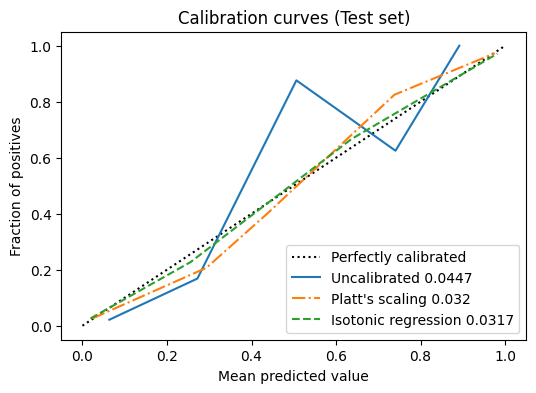

In [17]:
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(
    mean_predicted_value_uncalibrated,
    fraction_of_positives_uncalibrated,
    label="Uncalibrated %s" % round(brier_uncalibrated, 4),
)
plt.plot(
    mean_predicted_value_ps,
    fraction_of_positives_ps,
    label="Platt's scaling %s" % round(brier_platt, 4),
    linestyle="-.",
)
plt.plot(
    mean_predicted_value_ir,
    fraction_of_positives_ir,
    label="Isotonic regression %s" % round(brier_isotonic, 4),
    linestyle="--",
)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves (Test set)")
plt.legend(loc="lower right")
plt.show()